In [155]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

#### Source
The Container Ship Dataset is publicly available on [Kaggle](https://www.kaggle.com/c/airbus-ship-detection) and was created for the Airbus Ship Detection Challenge. It is designed for maritime object detection and segmentation tasks using satellite imagery.

##### Basics
- Source: Kaggle, Airbus Ship Detection Challenge  
- Size of dataset: ~32 Gb
- Number of images: 192,556
- Image resolution: 768 × 768 pixels (RGB)  
- Annotations: Run-Length Encoded (RLE) masks for each ship  
- Empty images: Some images contain no ships  
- Multiple ships per image: Many images have more than one ship, each represented by a separate RLE (one-to-many)

##### Dataset Structure
The annotations are provided as a CSV file (segmentations.csv) with columns:

| Column          | Description                                   |
|-----------------|-----------------------------------------------|
| `ImageId`       | Image filename                                |
| `EncodedPixels` | RLE mask for a single ship (empty if none)    |

- Images with multiple ships appear multiple times in the CSV.  
- Empty `EncodedPixels` indicates no ships in that image.

##### Data Folders, Files
- `cache/` – Precomputed or heavy computation outputs (e.g., cached mask analyses).  
- `images/` – Raw images from the dataset.  
- `original_segmentations.csv` – Pre-cleaned RLE CSVs for initial data exploration.  
- `segmentations.csv` – Cleaned segmentation CSVs (problematic masks handled).  
- `segmentations_with_split.csv` – Cleaned segmentations with train/validation/test split information.

##### Notes on Dataset Splits
- The original dataset provides a separate test set, but no annotations are available for the test images.  
- Therefore, we discarded the test set for our analysis and model training.  
- The original training set has been renamed to `images/` in our project folder structure.  
- Any further splitting for training, validation, and testing is done internally on this training set.

##### Validation Criteria
- Each RLE mask should correspond to a single boat, which is treated as a closed object. Consequently, every mask is expected to contain exactly one connected shape of reasonable size.

##### Methodology
1. Read in the segmentation CSV file.
2. Convert each RLE mask into a 2D binary mask.
3. For images with an RLE annotation, count the number of connected shapes in the mask and measure their sizes in pixels.
4. If a mask contains more than one shape or no shape reaches at least 12 pixels, mark it as problematic.
5. Visualize problematic images by displaying the image with the mask overlaid.

In [156]:
from utils import load_masks

In [157]:
load_masks(original = True).head(5)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                   
1  0001124c7.jpg                                                   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [158]:
from utils import get_2d_mask_from_rle
from utils import get_number_of_shapes_and_sizes

In [159]:
from tqdm import tqdm

def analyze_shapes_in_masks(masks_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute number of shapes and their sizes for each image RLE mask. 
    Skips any rows where 'EncodedPixels' is empty. 
    
    :param masks_df: DataFrame with columns 'ImageId' and 'EncodedPixels' 
    :return: DataFrame with columns 'ImageId', 'num_shapes', and 'shape_sizes' 
    """ 
    results = []
    for index, row in tqdm(masks_df.iterrows(), total=len(masks_df), desc="Analyzing masks"): 
        if not row.EncodedPixels: 
            continue

        mask = get_2d_mask_from_rle(row.EncodedPixels) 
        sizes = get_number_of_shapes_and_sizes(mask) 

        results.append({
            "index": index,
            "image_id": row.ImageId,
            "num_shapes": len(sizes), 
            "shape_sizes": sizes, 
        }) 
    return pd.DataFrame(results)

In [160]:
from utils import use_cache

In [161]:
masks = load_masks(original = True)
shapes = use_cache(analyze_shapes_in_masks)(masks)

num_images = shapes["image_id"].nunique()
print(f"Number of images analyzed: {num_images}")

mean_shapes = shapes["num_shapes"].mean()
min_shapes = shapes["num_shapes"].min()
max_shapes = shapes["num_shapes"].max()
print(f"Number of shapes per image -> mean: {mean_shapes:.2f}, min: {min_shapes}, max: {max_shapes}")

all_sizes = [s for sizes in shapes["shape_sizes"] for s in sizes]
print(f"Shape sizes -> mean: {np.mean(all_sizes):.2f}, min: {min(all_sizes)}, max: {max(all_sizes)}")

shapes.head(5)

Number of images analyzed: 42556
Number of shapes per image -> mean: 1.01, min: 1, max: 8
Shape sizes -> mean: 1557.59, min: 1, max: 25904


index       image_id  num_shapes shape_sizes
0      2  000155de5.jpg           1      [3388]
1      3  000194a2d.jpg           1       [177]
2      4  000194a2d.jpg           1       [148]
3      5  000194a2d.jpg           1       [480]
4      6  000194a2d.jpg           1         [7]

In [162]:
from utils import visualize_image_with_mask

In [163]:
from constants import MIN_SHAPE_SIZE

problematic_shapes = shapes[
    (shapes["num_shapes"] > 1) |
    (shapes["shape_sizes"].apply(lambda sizes: all(s < MIN_SHAPE_SIZE for s in sizes)))
]

print(f"Number of problematic shapes: {len(problematic_shapes)}")
print(f"Percentage problematic shapes: {len(problematic_shapes)/len(shapes)*100:.2f}%\n")

problematic_shapes.head(5)

Number of problematic shapes: 411
Percentage problematic shapes: 0.50%



index       image_id  num_shapes shape_sizes
4        6  000194a2d.jpg           1         [7]
97     281  00552a73d.jpg           2   [5226, 1]
638   1883  0219dec84.jpg           1        [10]
807   2271  02776139a.jpg           3  [30, 5, 2]
808   2272  02776139a.jpg           1         [2]


--- Problematic Image 53686 ---
ImageId: a811bd967.jpg
Number of shapes: 1
Shape sizes: [9]


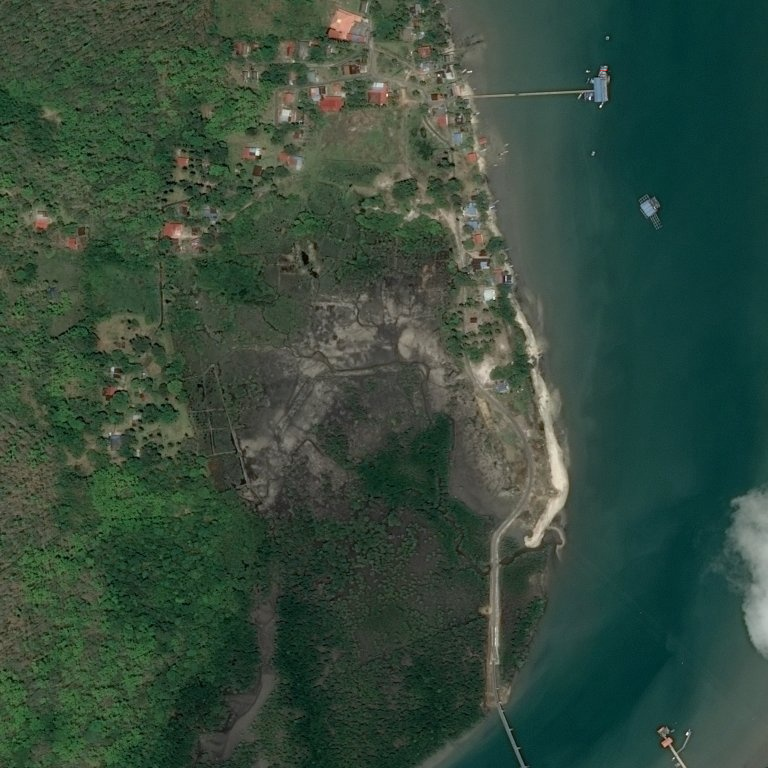


--- Problematic Image 43412 ---
ImageId: 87a819da8.jpg
Number of shapes: 1
Shape sizes: [10]


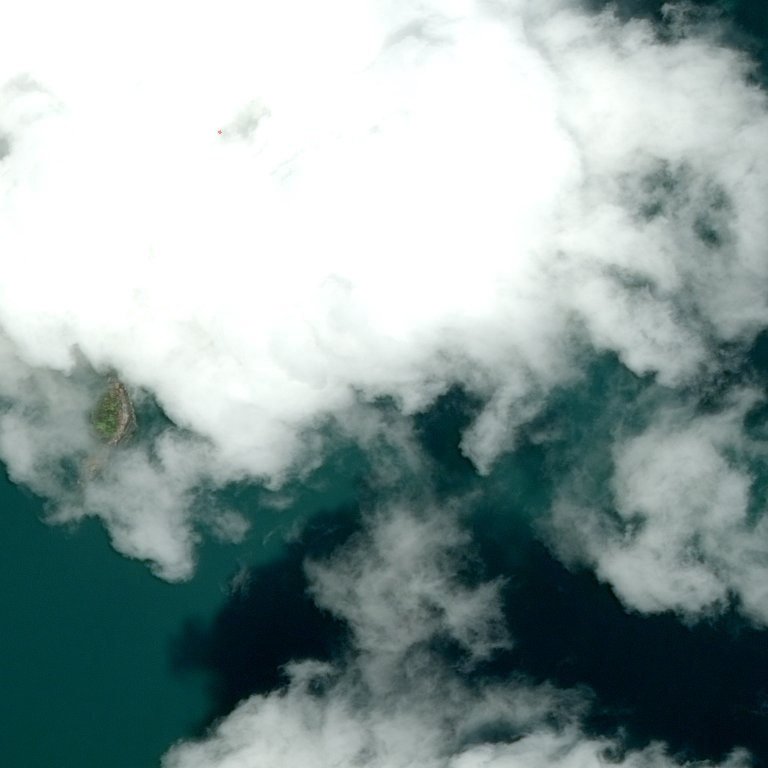


--- Problematic Image 54782 ---
ImageId: ab6bf8706.jpg
Number of shapes: 1
Shape sizes: [6]


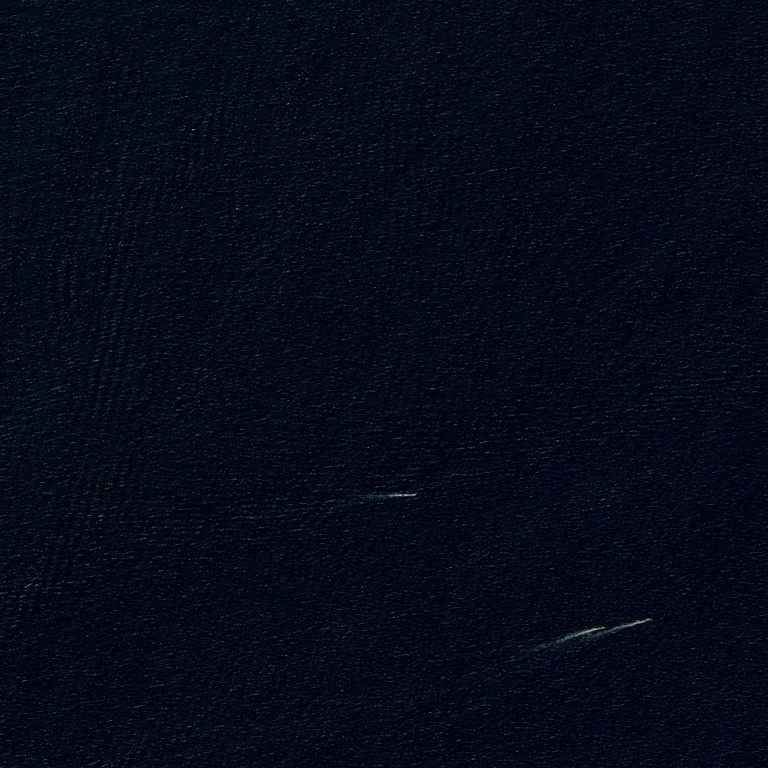

In [164]:
def analyze_problematic_shapes(
    problematic_shapes: pd.DataFrame,
    masks_df: pd.DataFrame,
    n_images: int = 3
):
    """
    Randomly display problematic images (images with more than one shape).

    :param problematic_shapes: DataFrame containing problematic mask information, returned by `analyze_shapes_in_masks()`
    :param masks_df: Original masks DataFrame with columns 'ImageId' and 'EncodedPixels'
    :param n_images: Number of random problematic images to display (default is 3)
    """
    if problematic_shapes.empty:
        print("No problematic images found!")
        return

    n_images = min(n_images, len(problematic_shapes))
    sampled_rows = problematic_shapes.sample(n=n_images)

    for i, row in sampled_rows.iterrows():
        original_index = row["index"]
        mask_row = masks_df.iloc[original_index]

        mask = get_2d_mask_from_rle(mask_row.EncodedPixels)

        print(f"\n--- Problematic Image {i+1} ---")
        print(f"ImageId: {mask_row.ImageId}")
        print(f"Number of shapes: {row.num_shapes}")
        print(f"Shape sizes: {row.shape_sizes}")

        visualize_image_with_mask(mask_row.ImageId, mask)
        
analyze_problematic_shapes(problematic_shapes, masks)

##### Validation Criteria
- Masks should not overlap, as two boats cannot occupy the same physical space in the image.

##### Methodology
1. Read in the segmentation CSV file.
2. Convert each RLE mask into a 2D binary mask.
3. Check for overlapping shapes across all masks of the same image.

In [165]:
from utils import rles_to_combined_mask, has_overlap

In [166]:

from constants import SHAPE

def analyze_mask_overlaps(masks_df: pd.DataFrame, shape = SHAPE) -> pd.DataFrame:
    """
    Analyze whether masks for each image overlap.

    :param masks_df: DataFrame containing mask RLEs with columns 'ImageId' and 'EncodedPixels'
    :param shape: Tuple of (height, width) specifying the dimensions of the 2D masks
    :return: DataFrame with columns 'image_id' and 'has_overlap' (True/False)
    """
    grouped = masks_df.groupby("ImageId")
    results = []

    for image_id, group in tqdm(grouped, desc="Analyzing masks"):
        rle_list = group["EncodedPixels"].tolist()
        
        combined_mask = rles_to_combined_mask(rle_list, shape)
        overlap = has_overlap(combined_mask)

        results.append({
            "image_id": image_id,
            "has_overlap": overlap,
        })
    
    return pd.DataFrame(results)

In [167]:
masks = load_masks(original = True, filter_empty = True)
overlaps = use_cache(analyze_mask_overlaps)(masks)

total_images = len(overlaps)
num_overlaps = overlaps["has_overlap"].sum()
percent_overlaps = num_overlaps / total_images * 100

print(f"Total images analyzed (with masks): {total_images}")
print(f"Number of images with overlapping masks: {num_overlaps}")
print(f"Percentage of overlapping images: {percent_overlaps:.2f}%\n")

Total images analyzed (with masks): 192556
Number of images with overlapping masks: 0
Percentage of overlapping images: 0.00%



## Data Cleaning

##### Methodology
- Remove masks with no valid shapes: If a mask contains no shapes larger than 12 pixels, discard the mask entirely.  
- Keep only the largest shape: For masks with multiple shapes, remove all shapes except the largest one to ensure each mask corresponds to a single boat.

In [168]:
from utils import keep_largest_shape, get_rle_from_2d_mask

In [169]:
masks = load_masks()
shapes = use_cache(analyze_shapes_in_masks)(masks)

problematic_images = shapes[
    (shapes["num_shapes"] > 1) |
    (shapes["shape_sizes"].apply(lambda sizes: all(s < MIN_SHAPE_SIZE for s in sizes)))
]

for _, row in problematic_images.iterrows():
    original_index = row["index"]
    mask_row = masks.iloc[original_index]

    mask = get_2d_mask_from_rle(mask_row.EncodedPixels)
    
    if all(s < MIN_SHAPE_SIZE for s in row.shape_sizes):
        masks.at[original_index, "EncodedPixels"] = ""
    
    else:
        cleaned_mask = keep_largest_shape(mask)
        new_rle = get_rle_from_2d_mask(cleaned_mask)
        masks.at[original_index, "EncodedPixels"] = new_rle
        
masks.to_csv("./data/segmentations.csv", index=False)


## Train / Validation / Test Split

##### Methodology
Since the original test set lacks annotations, we split the available training data into train, validation, and test subsets. This approach allows us to:

- Train models using the training set.  
- Tune hyperparameters and evaluate performance on the validation set.  
- Assess generalization on a hold-out test set derived from the original training data.  

The split should ideally be stratified, ensuring that images with and without ships are proportionally represented in each subset. A typical split is:

- 80% training  
- 10% validation  
- 10% test


In [170]:
from sklearn.model_selection import train_test_split

In [171]:
masks = pd.read_csv("./data/segmentations.csv")

masks['has_ship'] = masks['EncodedPixels'] != ""

train_val, test = train_test_split(
    masks, test_size=0.10, stratify=masks['has_ship'], random_state=42
)

train, val = train_test_split(
    train_val, test_size=0.10, stratify=train_val['has_ship'], random_state=42
) 

masks['split'] = ''
masks.loc[train.index, 'split'] = 'train'
masks.loc[val.index, 'split'] = 'val'
masks.loc[test.index, 'split'] = 'test'

masks.to_csv("./data/segmentations_with_split.csv", index=False)